# Predicting simulated data with different photon counts

This notebook involves predicting fluorescence lifetimes from the same image simulated with varying photon counts per pixel.<br>
Data were simulted with an **10, 20, 50, 80, and 100** photons per pixel. <br>
Three different examples are provided, namely `sample1`, `sample2`, `sample3`.

*Please note: Some variations in the photon counts per pixel may exist due to the addition of Poisson noise during data simulation.*

In [1]:
import os
import sys
import torch
import numpy as np, h5py
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import matplotlib.pyplot as plt

current_folder = globals()['_dh'][0]
print(current_folder)
os.chdir(os.path.join(current_folder, '..'))

from utils.eval_utils import normalise, visualise_images, load_tiff

from backbone.flimngo_net import GetModel
from tqdm import tqdm

C:\Users\User\Desktop\PhD\Projects\dl_flim\FLIMngo\demo_notebooks


In [2]:
# load cuda if available, if not choose cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preprocessing

- Load raw data from `.tiff` files with dimensions `(x, y, t)`.
- **Normalise** the time dimension to a range between 0 and 1.
- The **background has already** been masked during data simlation

*Please note: Some variations in the photon counts per pixel may exist due to the addition of Poisson noise during data simulation.*

In [3]:
dir = 'sample_data/simulated_data'
filenames = os.listdir(dir) # get list of filenames
bin_width = 0.09765625 # bin width in ns used for data simulation

In [4]:
# initialise dictionaries
data_dict = {}  # store raw and normalized data
gt_dict = {}    # store ground truth data

for filename in filenames:
    # remove the .tiff extension for dictionary key
    file_key = os.path.splitext(filename)[0]

    # check if the file is a ground truth image
    if "ground_truth" in file_key:
        # load the ground truth data and store it in gt_dict
        gt_dict[file_key] = load_tiff(dir=dir, filename=filename)
    
    else:
        # load raw data
        raw_data = load_tiff(dir=dir, filename=filename)
        # normalise the raw data along the time axis
        data_norm = normalise(data=raw_data)

        # store raw and normalised data in data_dict
        data_dict[file_key] = {
            'raw_data': raw_data,
            'normalised_data': data_norm
        }

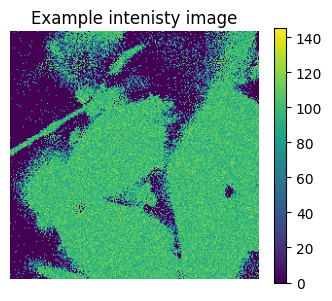

In [5]:
# visualise example intenisty image, before normalisation (i.e. raw data)
# this will ensure that images have been correctly loaded
plt.figure(figsize=(4, 3.3))  # set the figure size
plt.imshow(data_dict['sample1_photon_counts_100']['raw_data'].sum(0), )  # display the summed image (i.e. intensity)
plt.title("Example intenisty image")
plt.colorbar() 
plt.axis('off')
plt.show()

In [6]:
time = np.arange(0, 256) * bin_width # get time axis from bin width

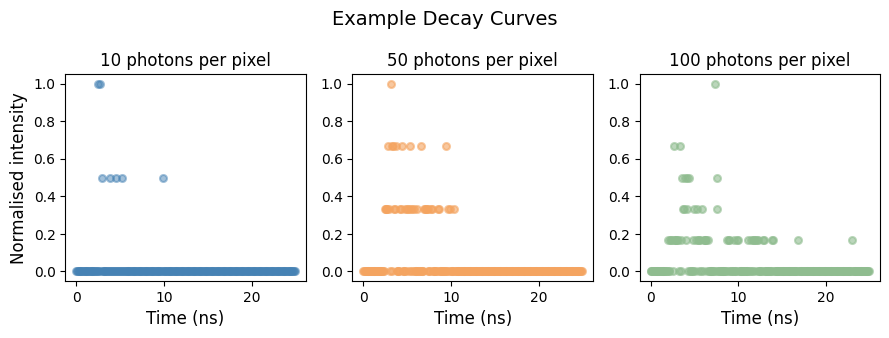

In [7]:
# visualise examples of normalized decay curves from images simulated with varying photon counts
# average photon counts per pixel are shown; variations may exist due to Poisson noise added during data simulation
fig, axes = plt.subplots(1, 3, figsize=(9, 3.4)) 

fig.suptitle("Example Decay Curves", fontsize=14)

# display example normalised decay curve from image simulated with an average of 10 photon counts per pixel
axes[0].scatter(time, data_dict['sample1_photon_counts_10']['normalised_data'][:, 32, 50], 
                c='steelblue', s=25, alpha=0.5, linewidth= 1.5)
axes[0].set_title('10 photons per pixel')
axes[0].set_ylabel("Normalised intensity", fontsize=12)  # Add y-axis label

# display example normalised decay curve from image simulated with an average of 50 photon counts per pixel
axes[1].scatter(time, data_dict['sample1_photon_counts_50']['normalised_data'][:, 32, 50], 
                c='sandybrown', s=25, alpha=0.6, linewidth= 1.5)
axes[1].set_title('50 photons per pixel')

# display example normalised decay curve from image simulated with an average of 100 photon counts per pixel
axes[2].scatter(time, data_dict['sample1_photon_counts_100']['normalised_data'][:, 32, 50], 
                c='darkseagreen', s=25, alpha=0.6, linewidth= 1.5)
axes[2].set_title('100 photons per pixel')

# add x-axis label to all subplots
for ax in axes:
    ax.set_xlabel("Time (ns)", fontsize=12)

plt.tight_layout()  # Leave space for the overall title

plt.show()

## Predict Data

#### Requirements for Model Predictions:
- **Image spatial dimensions** (where `x` and `y` must be equal)
- **Image time dimension** (currently supports only 256 time points)
- **Bin width** (in ns)


In [8]:
model_id ='flimngo_pretrained_v13102024.pth'

In [9]:
# set spatial (x,y) dimentions of images, only works for images with identical x and y dimentions
image_dimentions = 256
class Options:
        def __init__(self):
            self.model = 'flimngo'
            self.cpu = not torch.cuda.is_available() # set to True if you want to use CPU instead of GPU
            self.imageSize = image_dimentions  # set the desired image size 
            self.n_in_channels = 256 # number of time channels should be set to 256
            self.width_multiple = 0.5 # default 
            self.bin_width = bin_width # bin width of simulated data

# Create an instance of the options
opt = Options()
model = GetModel(opt).to(device=device)

In [10]:
# load the model
model.load_state_dict(torch.load(model_id, map_location=device))
model.eval()

# iterate over all filenames in the dictionary
for filename in tqdm(list(data_dict.keys()), desc="Predicting simulated data"):
    # prepare the normalised data as a tensor
    data_tensor = torch.tensor(data_dict[filename]['normalised_data'], dtype=torch.float32).unsqueeze(0).to(device)
    
    # predict lifetime
    with torch.no_grad():
        prediction = model(data_tensor).cpu().numpy()  # Move prediction to CPU and convert to NumPy

    # save the prediction in the dictionary under the same filename
    data_dict[filename]['predicted'] = prediction

Predicting simulated data: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.92it/s]


In [11]:
data_dict.keys()

dict_keys(['sample1_photon_counts_10', 'sample1_photon_counts_100', 'sample1_photon_counts_20', 'sample1_photon_counts_50', 'sample1_photon_counts_80', 'sample2_photon_counts_10', 'sample2_photon_counts_100', 'sample2_photon_counts_20', 'sample2_photon_counts_50', 'sample2_photon_counts_80', 'sample3_photon_counts_10', 'sample3_photon_counts_100', 'sample3_photon_counts_20', 'sample3_photon_counts_50', 'sample3_photon_counts_80'])

## Data Evaluation

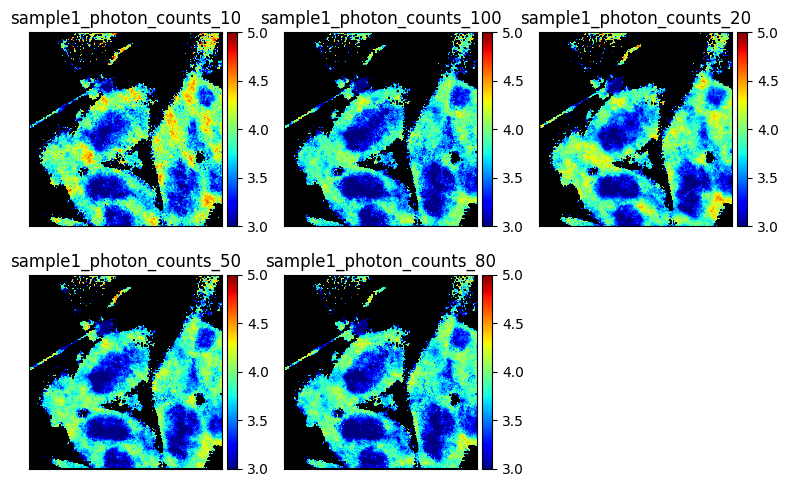

In [12]:
sample_id = 'sample1' # select which file to visualise, options: sample1, sample2, sample3

# extract predicted data for this samplet
predicted_ls = [data['predicted'] for filename, data in data_dict.items() if filename.startswith(sample_id)]
# list of corresponding filenames
filenames_ls = [filename for filename, data in data_dict.items() if filename.startswith(sample_id)]

vmin, vmax= 3, 5 # change colourbar range for different files

visualise_images(predicted_ls, filenames_ls, cmap_c='jet', vmin=vmin, vmax=vmax)

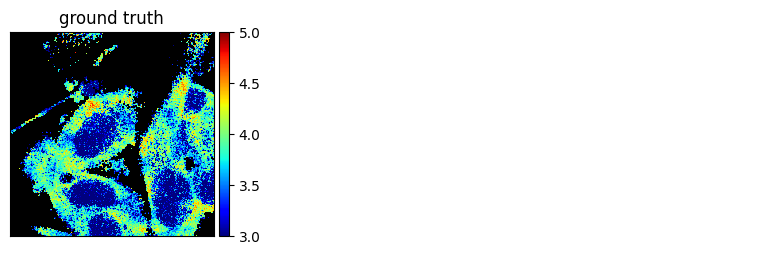

In [13]:
# visualise ground truth data
visualise_images([gt_dict[f'{sample_id}_ground_truth']], ['ground truth'], cmap_c='jet', vmin=vmin, vmax=vmax)

In [14]:
# calculate Mean Squared Error (MSE)  between model predictions and ground truth
# dictionary to store the MSE for each file
mse_scores = defaultdict(dict)

# calculate MSE for each file
for filename, data in data_dict.items():
    if 'predicted' in data:
        sample_id = filename.split('_')[0] # get sample id, e.g. sample_1
        # clatten arrays and replace NaNs with zeros
        predicted = np.nan_to_num(data['predicted'].flatten(), nan=0.0)
        ground_truth = np.nan_to_num(gt_dict[f'{sample_id}_ground_truth'].flatten(), nan=0.0)

        # calculate MSE
        mse = mean_squared_error(ground_truth, predicted)

        # extract sample and photon count from the filename (e.g., sample1_photon_counts_10)
        sample, photon_count = filename.split('_photon_counts_')
        mse_scores[sample][photon_count] = mse

# print the results in a grouped format
for sample, photon_mses in mse_scores.items():
    print(f"MSE between predictions and Ground truth image: {sample} ")
    for photon_count, mse in sorted(photon_mses.items(), key=lambda x: int(x[0])):
        print(f"MSE for {photon_count} photons per pixel = {mse:.3f}")
    print() 


MSE between predictions and Ground truth image: sample1 
MSE for 10 photons per pixel = 0.360
MSE for 20 photons per pixel = 0.280
MSE for 50 photons per pixel = 0.205
MSE for 80 photons per pixel = 0.167
MSE for 100 photons per pixel = 0.157

MSE between predictions and Ground truth image: sample2 
MSE for 10 photons per pixel = 0.131
MSE for 20 photons per pixel = 0.105
MSE for 50 photons per pixel = 0.089
MSE for 80 photons per pixel = 0.083
MSE for 100 photons per pixel = 0.081

MSE between predictions and Ground truth image: sample3 
MSE for 10 photons per pixel = 0.183
MSE for 20 photons per pixel = 0.135
MSE for 50 photons per pixel = 0.101
MSE for 80 photons per pixel = 0.093
MSE for 100 photons per pixel = 0.090

